# Predicting Wind Turbine Output with a Random Forest Regression

In this version of the random forest analysis, the data frame structure is a modification of the original data file. Each record in the data frame contains the turbine power output in a given zone, plus the wind velocity measurements in *all* zones, plus the year, day of the year, and time of the measurements. Depending on how the data were preprocessed (see notebook 1_data_preparation.ipynb), it is possible for the wind velocities to be rolling window averages over a fixed number of measurements.

1. [Imports.](#Cell1)
1. [Load preprocessed training data set and split it into training and testing subsets.](#Cell2)
1. [Do a grid search to find optimal hyper-parameters of the random forest regressor.](#Cell3)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell4)
1. [Examine fit results.](#Cell5)
1. [Make profile histograms of the residuals, model the corresponding bias correction, and apply it to the random forest results.](#Cell6)
1. [Fit best regressor to the entire training dataset.](#Cell7)
1. [Retrieve trained model from disk. Only run this cell if previous one wasn't run.](#Cell8)
1. [Prepare the test data set in the same way as the training set, make predictions, and create output csv file.](#Cell9)

<a id='Cell1'></a>

In [1]:
'''
Imports.
'''
import pandas as pd
import numpy as np
import scipy.optimize as optimization
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from time import strftime
from datetime import datetime
from operator import itemgetter
import csv

## Analysis of all turbines together

<a id='Cell2'></a>

In [11]:
'''
Load preprocessed training data set and split it into training and testing subsets.
'''
# Select training set size and preprocessed data file
N_train = 10000
TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl" # No rolling means
#TrainingDataFile = "data/Train_pp_2017_03_11_22_52_56.pkl" # Rolling means over 2 measurements
#TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl" # Rolling means over 3 measurements
#TrainingDataFile = "data/Train_pp_2017_03_11_02_06_50.pkl" # Rolling means over 4 measurements
#TrainingDataFile = "data/Train_pp_2017_03_27_17_43_43.pkl" # Rolling means over 3 measurements, dups removed

# Load data
df0 = pd.read_pickle(TrainingDataFile)
print('Shape of loaded data frame: {0}'.format(df0.shape))

# Rename dataframe columns and make lists with the new predictor and target labels
predictors  = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]!='TARGETVAR']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
targets     = [item[0]+'_'+str(item[1]) for item in df0.columns.values if item[0]=='TARGETVAR']
df0.columns = targets+predictors

# Split data set into training and testing subsets
df0_train, df0_test  = train_test_split(df0, train_size=N_train, random_state=0)

print('Shape of df0_train:         {0}'.format(df0_train.shape))
print('Shape of df0_test:          {0}'.format(df0_test.shape))
print('\nPredictor variables: {0}'.format(predictors))

Shape of loaded data frame: (13871, 53)
Shape of df0_train:         (10000, 53)
Shape of df0_test:          (3871, 53)

Predictor variables: ['U10_1', 'U10_2', 'U10_3', 'U10_4', 'U10_5', 'U10_6', 'U10_7', 'U10_8', 'U10_9', 'U10_10', 'V10_1', 'V10_2', 'V10_3', 'V10_4', 'V10_5', 'V10_6', 'V10_7', 'V10_8', 'V10_9', 'V10_10', 'U100_1', 'U100_2', 'U100_3', 'U100_4', 'U100_5', 'U100_6', 'U100_7', 'U100_8', 'U100_9', 'U100_10', 'V100_1', 'V100_2', 'V100_3', 'V100_4', 'V100_5', 'V100_6', 'V100_7', 'V100_8', 'V100_9', 'V100_10', 'YEAR', 'DAYOFYEAR', 'HOUR']


<a id='Cell3'></a>

In [3]:
'''
Do a grid search to find optimal hyper-parameters of the random forest regressor.
We use the RMSE to score parameter choices.

(This cell can be omitted if the previous one was run.)
'''

# Specify the parameter grid to be searched
parameter_grid = [{'n_estimators': [1000, 2000, 3000], 'max_depth': [30, 40, 50], 
                   'min_samples_leaf': [3, 5, 7]}]

# Start the grid search
rfo = GridSearchCV(RandomForestRegressor(criterion='mse', min_samples_split=2, max_features="sqrt",
                                         max_leaf_nodes=None, bootstrap=True, oob_score=True, 
                                         n_jobs=-1, random_state=0, verbose=0),
                   parameter_grid, refit=True, cv=5, scoring='neg_mean_squared_error')
%time rfo.fit(df0_train[predictors], df0_train[targets])

# Print out the results (flipping the sign on the grid scores to make them positive again).
print("Best parameter values found on development set:")
print(" ")
print(rfo.best_params_)
print(" ")
print("Grid scores on development set:")
print(" ")
for mean_score, std_score, settings in zip(rfo.cv_results_['mean_test_score'], 
                                           rfo.cv_results_['std_test_score'],
                                           rfo.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r" %(-mean_score, 2*std_score, settings))

# Retrieve best random forest model from grid search
rfr_train = rfo.best_estimator_
print("\nBest estimator:\n%s" %rfr_train)

fName = 'rfr_train_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(rfr_train, path_to_file)
print('\nRandom forest regression model saved to {0}'.format(path_to_file))

CPU times: user 5h 9min 13s, sys: 6min 51s, total: 5h 16min 4s
Wall time: 1h 45min 49s
Best parameter values found on development set:
 
{'n_estimators': 3000, 'max_depth': 40, 'min_samples_leaf': 3}
 
Grid scores on development set:
 
0.01938 (+/-0.00067) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 3}
0.01936 (+/-0.00067) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 3}
0.01936 (+/-0.00066) for {'n_estimators': 3000, 'max_depth': 30, 'min_samples_leaf': 3}
0.02120 (+/-0.00071) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 5}
0.02120 (+/-0.00072) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 5}
0.02119 (+/-0.00072) for {'n_estimators': 3000, 'max_depth': 30, 'min_samples_leaf': 5}
0.02249 (+/-0.00071) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 7}
0.02248 (+/-0.00071) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 7}
0.02247 (+/-0.00072) for {'n_estimators': 3000, 'max_depth':

<a id='Cell4'></a>

In [ ]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

rfr_found = True

try:
    rfr_train
except:
#    fName = 'rfr_train_2017_03_15_15_45_58' # rm=0
    fName = 'rfr_train_2017_04_04_14_47_29' # rm=3, dups removed
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        rfr_train = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        rfr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if rfr_found:
    print("Estimator:\n\n%s\n" %rfr_train)

<a id='Cell5'></a>

Estimator currently in use:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)


Results:
                                  Train     Test
Number of instances =             10000,     3871
Mean y_true =                     0.343781, 0.346975
Mean y_pred =                     0.343389, 0.346371
Minimum y_pred =                  0.001953, 0.004820
Maximum y_pred =                  0.975988, 0.964986
Standard deviation y_true =       0.303651, 0.307420
Standard deviation y_pred =       0.259911, 0.249821
RMSE (uniform average) =          0.091896, 0.134928
R^2 (uniform average) =           0.902759, 0.795650
R^2 (variance weighted average) = 0.904299, 0.798086
 


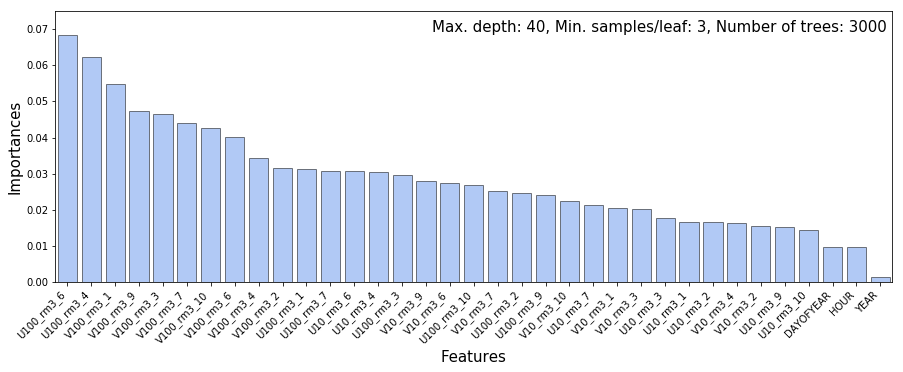

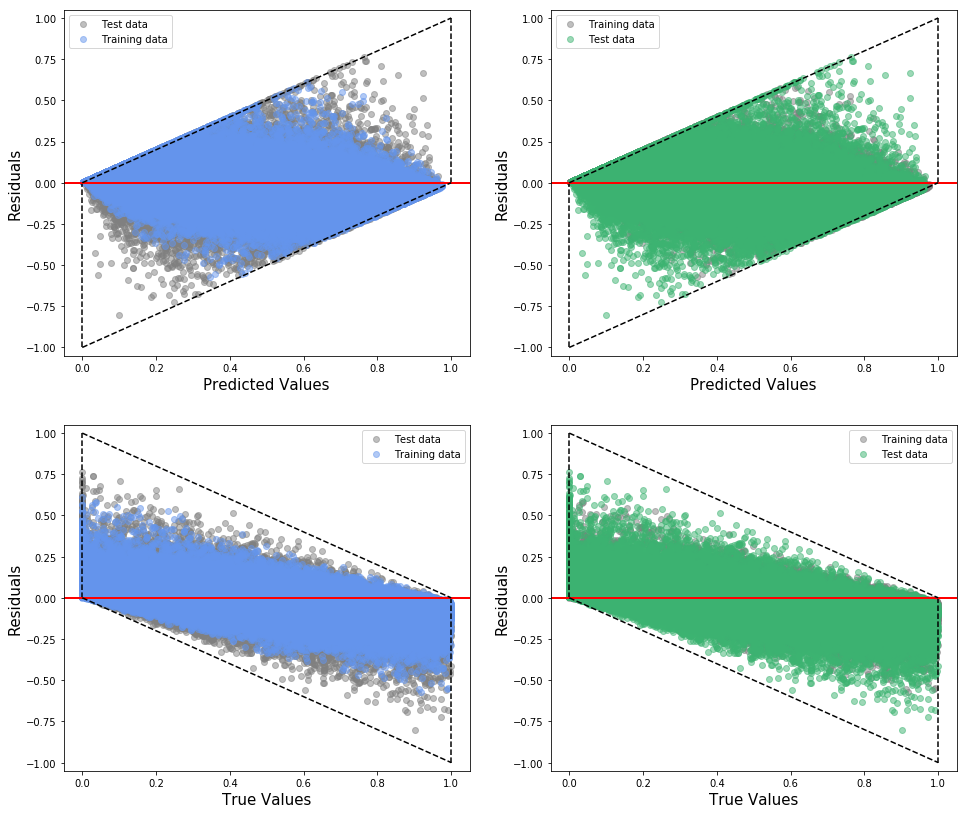

In [4]:
'''
Examine fit results.
'''
%matplotlib inline

print("Estimator currently in use:\n\n%s\n" %rfr_train)

# Make predictions on train and test set and compute evaluation metric (RMSE).
y_test       = df0_test[targets].as_matrix()
y_train      = df0_train[targets].as_matrix()
y_test_pred  = rfr_train.predict(df0_test[predictors])
y_train_pred = rfr_train.predict(df0_train[predictors])
print('\nResults:')
print('                                  Train     Test')
print('Number of instances =             %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =                     %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =                     %f, %f' %(y_train_pred.mean(),y_test_pred.mean()))
print('Minimum y_pred =                  %f, %f' %(y_train_pred.min(),y_test_pred.min()))
print('Maximum y_pred =                  %f, %f' %(y_train_pred.max(),y_test_pred.max()))
print('Standard deviation y_true =       %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred =       %f, %f' %(y_train_pred.std(),y_test_pred.std()))
print('RMSE (uniform average) =          %f, %f'\
      %(np.sqrt(mean_squared_error(y_train,y_train_pred,multioutput='uniform_average')),
        np.sqrt(mean_squared_error(y_test,y_test_pred,multioutput='uniform_average'))))
print('R^2 (uniform average) =           %f, %f'\
      %(r2_score(y_train,y_train_pred,multioutput='uniform_average'),
        r2_score(y_test,y_test_pred,multioutput='uniform_average')))
print('R^2 (variance weighted average) = %f, %f'\
      %(r2_score(y_train,y_train_pred,multioutput='variance_weighted'),
        r2_score(y_test,y_test_pred,multioutput='variance_weighted')))
print(' ')

# Plot feature importances, sorted in decreasing order
importances = rfr_train.feature_importances_
indices     = np.argsort(importances)[::-1]
n_features  = indices.size
bins        = np.arange(n_features)
x_labels    = np.array(predictors)[indices][:n_features]
maxHeight   = 1.10*max(importances)
fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.bar(bins, importances[indices][:n_features], align="center", color="cornflowerblue", edgecolor="k", alpha=0.5)
axes.set_xlabel("Features", fontsize=15)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45.)
axes.set_xlim([-0.5,bins.size-0.5])
axes.set_ylabel("Importances", fontsize=15)
axes.set_ylim([0.0, maxHeight])
rfr_parameters = rfr_train.get_params()
mx_dpth = rfr_parameters['max_depth']
mn_s_lf = rfr_parameters['min_samples_leaf']
n_trees = rfr_parameters['n_estimators']
axes.text(0.45, 0.92, 
          'Max. depth: {0}, Min. samples/leaf: {1}, Number of trees: {2}'.format(mx_dpth,mn_s_lf,n_trees),
          fontsize=15, transform=axes.transAxes)
plt.show()
#fig.savefig('FeatureImportances.png', dpi=200, bbox_inches='tight')

def plot_residuals(y1true, y1pred, y1label, y2true, y2pred, y2label, ax, xtype, y2color ):
    xval = np.array([0.0,1.0])
    if xtype==1:
        ax.scatter(y1true, y1pred-y1true, color="grey", alpha=0.5, marker="o", label=y1label)
        ax.scatter(y2true, y2pred-y2true, color=y2color, alpha=0.5, marker="o", label=y2label)
        ax.set_xlabel("True Values", fontsize=15)
        ax.legend(loc="upper right")
        ax.plot(xval, -xval, 'k--')
        ax.plot(xval, 1.0-xval, 'k--')
        ax.vlines(x=[0.0,1.0], ymin=[0.0,-1.0], ymax=[1.0,0.0], linestyles='dashed')
    else:
        ax.scatter(y1pred, y1pred-y1true, color="grey", alpha=0.5, marker="o", label=y1label)
        ax.scatter(y2pred, y2pred-y2true, color=y2color, alpha=0.5, marker="o", label=y2label)
        ax.set_xlabel("Predicted Values", fontsize=15)
        ax.legend(loc="upper left")
        ax.plot(xval, xval, 'k--')
        ax.plot(xval, xval-1.0, 'k--')
        ax.vlines(x=[0.0,1.0], ymin=[-1.0,0.0], ymax=[0.0,1.0], linestyles='dashed')
    ax.hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-1.05, 1.05])
    ax.set_ylabel("Residuals", fontsize=15)
    return
    
# Plot residuals
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,14))
plot_residuals(y_test, y_test_pred, "Test data", y_train, y_train_pred, "Training data", 
               axes[0,0], 0, "cornflowerblue")
plot_residuals(y_train, y_train_pred, "Training data", y_test, y_test_pred, "Test data", 
               axes[0,1], 0, "mediumseagreen")
plot_residuals(y_test, y_test_pred, "Test data", y_train, y_train_pred, "Training data", 
               axes[1,0], 1, "cornflowerblue")
plot_residuals(y_train, y_train_pred, "Training data", y_test, y_test_pred, "Test data", 
               axes[1,1], 1, "mediumseagreen")
plt.show()

<a id='Cell6'></a>


Results:
                                  Train     Test
Number of instances =             10000,     3871
Mean y_true =                     0.343781, 0.346975
Mean y_pred =                     0.343898, 0.346981
Minimum y_pred =                  -0.015264, -0.013042
Maximum y_pred =                  0.999696, 0.992933
Standard deviation y_true =       0.303651, 0.307420
Standard deviation y_pred =       0.292000, 0.282166
RMSE (uniform average) =          0.085943, 0.131953
R^2 (uniform average) =           0.915073, 0.805110
R^2 (variance weighted average) = 0.916296, 0.806893
 


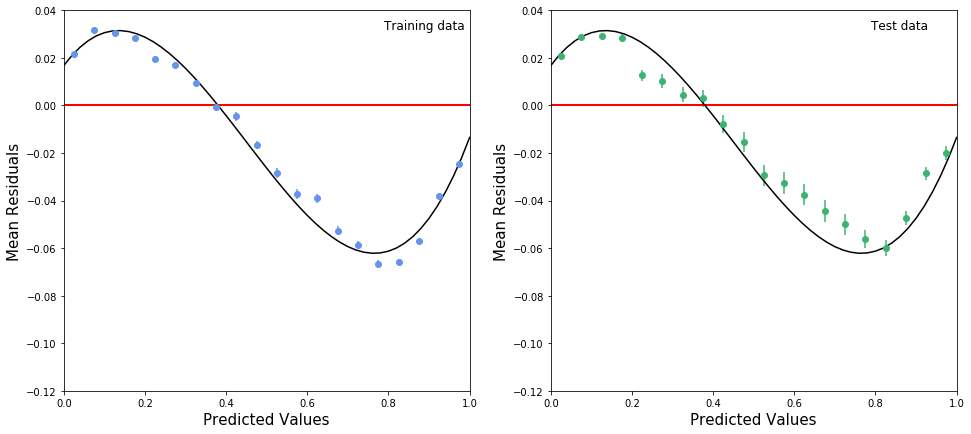

In [5]:
'''
Make profile histograms of the residuals, model the corresponding bias correction, 
and apply it to the random forest results.
'''

def profile( x, y, nbins, xmin, xmax, fmean, fstd ):
    '''
    Given two data arrays of the same length x and y, computes a profile
    histogram of nbins between xmin and xmax. Returns the bin centers in
    xmids, and the y means and standard deviations within bins in ymeans
    and ystds. fmean is a fake mean to be used when a bin is empty, and
    fstd is a fake standard deviation to be used when a bin contains only
    one element.
    '''
    deltax = (xmax-xmin)/nbins
    xbins  = np.arange(xmin, xmax+deltax, deltax)
    xmids  = [(xbins[ind]+xbins[ind+1])/2 for ind in range(nbins)]
    xf     = np.array(x).flatten()
    yf     = np.array(y).flatten()
    ymeans = []
    ystds  = []
    for ibin in range(nbins):
        y_elements = np.array([yval for (xval,yval) in zip(xf,yf) if xval>=xbins[ibin] and xval<xbins[ibin+1]])
        ylen       = len(y_elements)
        if ylen>0:
            ymeans.append(y_elements.mean())
        else:
            ymeans.append(fmean)
        if ylen>1:
            ystds.append(y_elements.std()/np.sqrt(ylen))
        else:
            ystds.append(fstd)
    return (xmids,ymeans,ystds)

# Compute residual profiles
xtn_mids,rtn_means,rtn_stds = profile( y_train_pred, y_train_pred-y_train, 20, 0.0, 1.0, 0.0, 1.0)
xtt_mids,rtt_means,rtt_stds = profile( y_test_pred, y_test_pred-y_test, 20, 0.0, 1.0, 0.0, 1.0)

# Fit the profiles
def rfbias(x, a, b, c, d):
    return a + b*x + c*x*x + d*x*x*x
fitpar,covmat = optimization.curve_fit(rfbias, xtn_mids, rtn_means, p0=None, sigma=rtn_stds, 
                                       absolute_sigma=True, check_finite=True )

# Apply corresponding bias correction to random forest regressor output, and recompute RMSE.
y_train_pred_corr = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_train_pred])
y_test_pred_corr  = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_test_pred])

print('\nResults:')
print('                                  Train     Test')
print('Number of instances =             %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =                     %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =                     %f, %f' %(y_train_pred_corr.mean(),y_test_pred_corr.mean()))
print('Minimum y_pred =                  %f, %f' %(y_train_pred_corr.min(),y_test_pred_corr.min()))
print('Maximum y_pred =                  %f, %f' %(y_train_pred_corr.max(),y_test_pred_corr.max()))
print('Standard deviation y_true =       %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred =       %f, %f' %(y_train_pred_corr.std(),y_test_pred_corr.std()))
print('RMSE (uniform average) =          %f, %f' \
      %(np.sqrt(mean_squared_error(y_train,y_train_pred_corr,multioutput='uniform_average')),
        np.sqrt(mean_squared_error(y_test,y_test_pred_corr,multioutput='uniform_average'))))
print('R^2 (uniform average) =           %f, %f' \
      %(r2_score(y_train,y_train_pred_corr,multioutput='uniform_average'),
        r2_score(y_test,y_test_pred_corr,multioutput='uniform_average')))
print('R^2 (variance weighted average) = %f, %f' \
      %(r2_score(y_train,y_train_pred_corr,multioutput='variance_weighted'),
        r2_score(y_test,y_test_pred_corr,multioutput='variance_weighted')))
print(' ')

# Plot results
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,7))
xvals = np.arange(0.0,1.02,0.02)
yvals = np.array([rfbias(xval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for xval in xvals])
axes[0].errorbar(xtn_mids, rtn_means, yerr=rtn_stds, fmt='o', color='cornflowerblue')
axes[0].plot(xvals, yvals, 'k-')
axes[0].set_xlabel("Predicted Values", fontsize=15)
axes[0].set_ylabel("Mean Residuals", fontsize=15)
axes[0].text(0.79, 0.95, 'Training data', fontsize=12, transform=axes[0].transAxes)
axes[0].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([-0.12, 0.04])

axes[1].errorbar(xtt_mids, rtt_means, yerr=rtt_stds, fmt='o', color='mediumseagreen')
axes[1].plot(xvals, yvals, 'k-')
axes[1].set_xlabel("Predicted Values", fontsize=15)
axes[1].set_ylabel("Mean Residuals", fontsize=15)
axes[1].text(0.79, 0.95, 'Test data', fontsize=12, transform=axes[1].transAxes)
axes[1].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([-0.12, 0.04])
plt.show()

## Prepare test data set for submission

<a id='Cell7'></a>

In [8]:
'''
Fit best regressor to the entire training dataset.
'''

settings = rfr_train.get_params()
rfr      = RandomForestRegressor(**settings)
print('Estimator currently in use: \n\n{0}\n'.format(rfr))

%time rfr.fit(df0[predictors], df0[targets])

fName = 'rfr_' + strftime("%Y_%m_%d_%H_%M_%S")
path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(rfr, path_to_file)
print('\nRandom forest regression model saved to {0}'.format(path_to_file))

Estimator currently in use: 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

CPU times: user 3min 24s, sys: 2.18 s, total: 3min 26s
Wall time: 1min 16s

Random forest regression model saved to fitted_models/rfr_2017_04_04_22_44_20.model


<a id='Cell8'></a>

In [1]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

rfr_found = True

try:
    rfr
except:
#    fName = 'rfr_2017_03_15_16_36_11' # rm=0
    fName = 'rfr_2017_04_04_15_45_20' # rm=3, dups removed
    path_to_file = 'fitted_models/'+fName+'.model'
    try:
        rfr = joblib.load(path_to_file)
    except:
        print('Error loading regression model from {0}\n'.format(path_to_file))
        rfr_found = False
    else:
        print('Regression model successfully loaded from {0}\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

if rfr_found:
    print("Estimator:\n\n%s\n" %rfr)

Error loading regression model from fitted_models/rfr_2017_04_04_15_45_20.model



<a id='Cell9'></a>

In [13]:
'''
Prepare the test data set in the same way as the training set, make predictions, and create output csv file.
'''

# Load testing data appropriate to rolling mean setting:
if predictors[0][6:7].isdigit():
    rm = int(predictors[0][6:7])
else:
    rm = 1
if rm==1:
    TestingDataFile = "data/Test_pp_2017_03_02_15_47_36.pkl"
elif rm==2:
    TestingDataFile = "data/Test_pp_2017_03_12_10_32_09.pkl"
elif rm==3:
#    TestingDataFile = "data/Test_pp_2017_03_10_15_38_00.pkl"
    TestingDataFile = "data/Test_pp_2017_03_28_09_02_52.pkl" # rm=3, dups removed
elif rm==4:
    TestingDataFile = "data/Test_pp_2017_03_11_02_07_04.pkl"
df1 = pd.read_pickle(TestingDataFile)

# Rename dataframe columns and make lists with the new predictor labels
predictors  = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]!='ID']
predictors  = [predictor if predictor[-1]!='_' else predictor[:-1] for predictor in predictors]
ids         = [item[0]+'_'+str(item[1]) for item in df1.columns.values if item[0]=='ID']
df1.columns = ids+predictors
print('\nPredictor variables: {0}'.format(predictors))

# Count how many sets of observations we have in August and September 2013
nTotal      = len(df1)
nAugSep2013 = len([DoY for DoY in df1['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            {0}'.format(nTotal))
print('Number of observation times in August and September 2013: {0}\n'.format(nAugSep2013))

# Compute predictions for test set.
ttX  = df1.as_matrix(columns=predictors)
tty  = rfr.predict(ttX).flatten()
ttid = df1.as_matrix(columns=ids).flatten()

# Generate output csv file
fName_out = 'data/rfr_' + strftime("%Y_%m_%d_%H_%M_%S") + '.out.csv'
with open(fName_out, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID", "TARGETVAR"])
    for idval, yval in zip(ttid, tty):
        writer.writerow([idval, yval])
print('Output written to {0}'.format(fName_out))


Predictor variables: ['U10_1', 'U10_2', 'U10_3', 'U10_4', 'U10_5', 'U10_6', 'U10_7', 'U10_8', 'U10_9', 'U10_10', 'V10_1', 'V10_2', 'V10_3', 'V10_4', 'V10_5', 'V10_6', 'V10_7', 'V10_8', 'V10_9', 'V10_10', 'U100_1', 'U100_2', 'U100_3', 'U100_4', 'U100_5', 'U100_6', 'U100_7', 'U100_8', 'U100_9', 'U100_10', 'V100_1', 'V100_2', 'V100_3', 'V100_4', 'V100_5', 'V100_6', 'V100_7', 'V100_8', 'V100_9', 'V100_10', 'YEAR', 'DAYOFYEAR', 'HOUR']

Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

Output written to data/rfr_2017_04_04_22_49_03.out.csv
